In [1]:
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages")

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import time

In [3]:
capture = cv2.VideoCapture("flyover1.mp4")
print(capture)

#if(capture.isOpened()):
#    handle, frame = capture.read()
#    if(handle):
#        cv2.imshow("Frame", frame)
        
#        if(cv2.waitKey(25) & 0xFF == ord('q')):
#            cv2.destroyAllWindows()

#else:
#    print("Error reading the video file")'''

< cv2.VideoCapture 0x13072b5b0>


In [4]:
N_FRAMES = capture.get(cv2.CAP_PROP_FRAME_COUNT)
FPS = capture.get(cv2.CAP_PROP_FPS)
VIDEO_LENGTH = N_FRAMES/ FPS

print("No of Frames: ", N_FRAMES)
print("FPS: ",FPS)
print("Length: ", VIDEO_LENGTH)

No of Frames:  900.0
FPS:  30.0
Length:  30.0


In [5]:
yBlue = []
yGreen = []
yRed = []

start = time.time()

while not capture.isOpened():
    capture = cv2.VideoCapture("flyover1.mp4")

pointerFrame = capture.get(cv2.CAP_PROP_POS_FRAMES)
attempts = 0
current = pointerFrame

while True:
    flag, frame = capture.read()
    
    if flag:
        # Frame is ready and already captured
        # hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        yBlue.append(frame[:, :, 0])
        yGreen.append(frame[:, :, 1])
        yRed.append(frame[:, :, 2])
        # print(pointerFrame)
        current = pointerFrame
        pointerFrame = capture.get(cv2.CAP_PROP_POS_FRAMES)
        
    else:
        # Frame is not ready
        
        if(current == pointerFrame and attempts > 10):
            attempts = 0
            break
        else:           
            #print("Not Ready")
            attempts += 1
            capture.set(cv2.CAP_PROP_POS_FRAMES, pointerFrame - 1)      
        
    if N_FRAMES == cv2.CAP_PROP_POS_FRAMES:
        break
        
if (int(N_FRAMES) < len(yBlue)):
    yBlue = yBlue[0: int(N_FRAMES)]
    yGreen = yGreen[0: int(N_FRAMES)]
    yRed = yRed[0: int(N_FRAMES)]
    
end = time.time()

yBlue = np.array(yBlue)
yGreen = np.array(yGreen)
yRed = np.array(yRed)

print("Execution Time: ", end - start)
print(len(yBlue), len(yGreen), len(yRed))

Execution Time:  3.0885770320892334
900 900 900


In [6]:
summarizedBlue = []
summarizedGreen = []
summarizedRed = []

start = time.time()

for i in range(len(yBlue)):
    summarizedBlue.append(sum(yBlue[i]))
    summarizedGreen.append(sum(yGreen[i]))
    summarizedRed.append(sum(yRed[i]))

summarizedBlue = np.array(summarizedBlue)   
summarizedGreen = np.array(summarizedGreen) 
summarizedRed = np.array(summarizedRed) 

end = time.time()

print("Execution time: ", end - start)
print(summarizedBlue.shape)
print(summarizedGreen.shape)
print(summarizedRed.shape)

Execution time:  2.2418789863586426
(900, 1280)
(900, 1280)
(900, 1280)


In [7]:
speed_of_light = 3* pow(10,8)

blueFrequencies = np.array([speed_of_light/ (((90* pow(10, -9)* summarizedBlue[i])/255) + 440* pow(10, -9)) 
                  if ((300 * pow(10, -9) * summarizedBlue[i])/255).all() != 0 
                  else np.array([0.0]*summarizedBlue[i]) for i in range(summarizedBlue.shape[0])])

greenFrequencies = np.array([speed_of_light/ (((95* pow(10, -9)* summarizedGreen[i])/255) + 490* pow(10, -9)) 
                  if ((300 * pow(10, -9) * summarizedGreen[i])/255).all() != 0 
                  else np.array([0.0]*summarizedGreen[i]) for i in range(summarizedRed.shape[0])])

redFrequencies = np.array([speed_of_light/ (((210* pow(10, -9)* summarizedRed[i])/ 255) + 520* pow(10, -9)) 
                  if ((300 * pow(10, -9) * summarizedRed[i])/255).all() != 0 
                  else np.array([0.0]*summarizedRed[i]) for i in range(summarizedRed.shape[0])])

print(type(blueFrequencies), blueFrequencies.shape, blueFrequencies[50])
print(type(greenFrequencies), greenFrequencies.shape, greenFrequencies[50])
print(type(redFrequencies), redFrequencies.shape, redFrequencies[50])

<class 'numpy.ndarray'> (900, 1280) [0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'> (900, 1280) [0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'> (900, 1280) [0. 0. 0. ... 0. 0. 0.]


In [8]:
minBlue = np.min(blueFrequencies)
maxBlue = np.max(blueFrequencies)
minGreen = np.min(greenFrequencies)
maxGreen = np.max(greenFrequencies)
minRed = np.min(redFrequencies)
maxRed = np.max(redFrequencies)

blueFrequencies = np.array([(((blueFrequencies[i] - minBlue)*(2637.0 - 196.0)) / (maxBlue - minBlue + 1)) + 196.0 for i in range(len(blueFrequencies))])
greenFrequencies = np.array([(((greenFrequencies[i] - minGreen)*(1046.5 - 130.8)) / (maxGreen - minGreen + 1)) + 130.8 for i in range(len(greenFrequencies))])
redFrequencies = np.array([(((redFrequencies[i] - minRed)*(659.3 - 65.4)) / (maxRed - minRed + 1)) + 65.4 for i in range(len(redFrequencies))])

print(minBlue, maxBlue)
print(minGreen, maxGreen)   
print(minRed, maxRed) 

0.0 681271707186748.6
0.0 611779759286656.8
0.0 576010842557036.4


In [9]:
SAMPLE_RATE = FPS*N_FRAMES
AMPLITUDE = 8192

In [10]:
def get_wave(frequency, duration = 0.5):
    t = np.linspace(0, duration, int(SAMPLE_RATE*duration))
    wave = AMPLITUDE * np.sin(2* np.pi* frequency* t) # A sin(2*pi*f*t)
    return wave

In [11]:
finalBlue = []
finalGreen = []
finalRed = []

n = 0

while n < (int(N_FRAMES)):
    finalBlue.append(sum(blueFrequencies[n: n+int(FPS)])/FPS)
    finalGreen.append(sum(greenFrequencies[n: n+int(FPS)])/FPS)
    finalRed.append(sum(redFrequencies[n: n+int(FPS)])/FPS)
    n += int(FPS)

print(len(finalBlue), len(finalGreen), len(finalRed))

30 30 30


In [12]:
# Making waves based of BGR Frequencies

blueWave1 = []
greenWave1 = []
redWave1 = []

time = 1

for i in range(len(finalBlue)):
    blueWave1.append(get_wave(sum(finalBlue[i])/FPS, time))
    greenWave1.append(get_wave(sum(finalGreen[i])/FPS, time))
    redWave1.append(get_wave(sum(finalRed[i])/FPS, time))

blueWave1 = np.concatenate(np.array(blueWave1))
greenWave1 = np.concatenate(np.array(greenWave1))
redWave1 = np.concatenate(np.array(redWave1))

print(len(blueWave1), len(greenWave1), len(redWave1))

810000 810000 810000


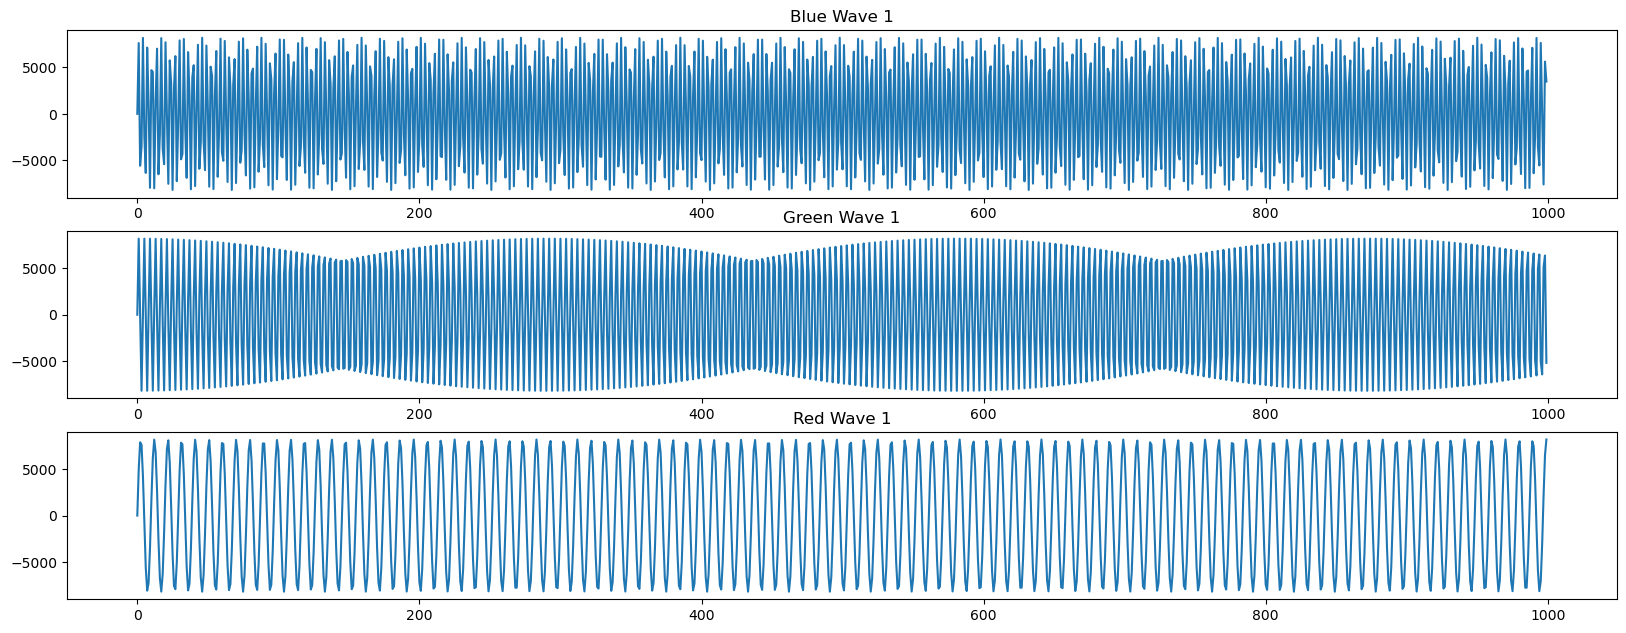

In [13]:
plt.figure(figsize=(20,10))

plt.subplot(4,1,1)
plt.plot(blueWave1[0: 1000])
plt.subplot(4,1,1).set_title("Blue Wave 1")

plt.subplot(4,1,2)
plt.plot(greenWave1[0:1000])
plt.subplot(4,1,2).set_title("Green Wave 1")

plt.subplot(4,1,3)
plt.plot(redWave1[0:1000])
plt.subplot(4,1,3).set_title("Red Wave 1")

plt.show()

In [14]:
waves = [blueWave1, greenWave1, redWave1] #[blueWave1, blueWave2, greenWave1, greenWave2, redWave1, redWave2]
maxCols = max(wave.shape[0] for wave in waves)

blueWave1 = np.hstack((blueWave1, np.zeros(maxCols - blueWave1.shape[0])))
greenWave1 = np.hstack((greenWave1, np.zeros(maxCols - greenWave1.shape[0])))
redWave1 = np.hstack((redWave1, np.zeros(maxCols - redWave1.shape[0])))
     
combinedWave = blueWave1 + greenWave1 + redWave1 

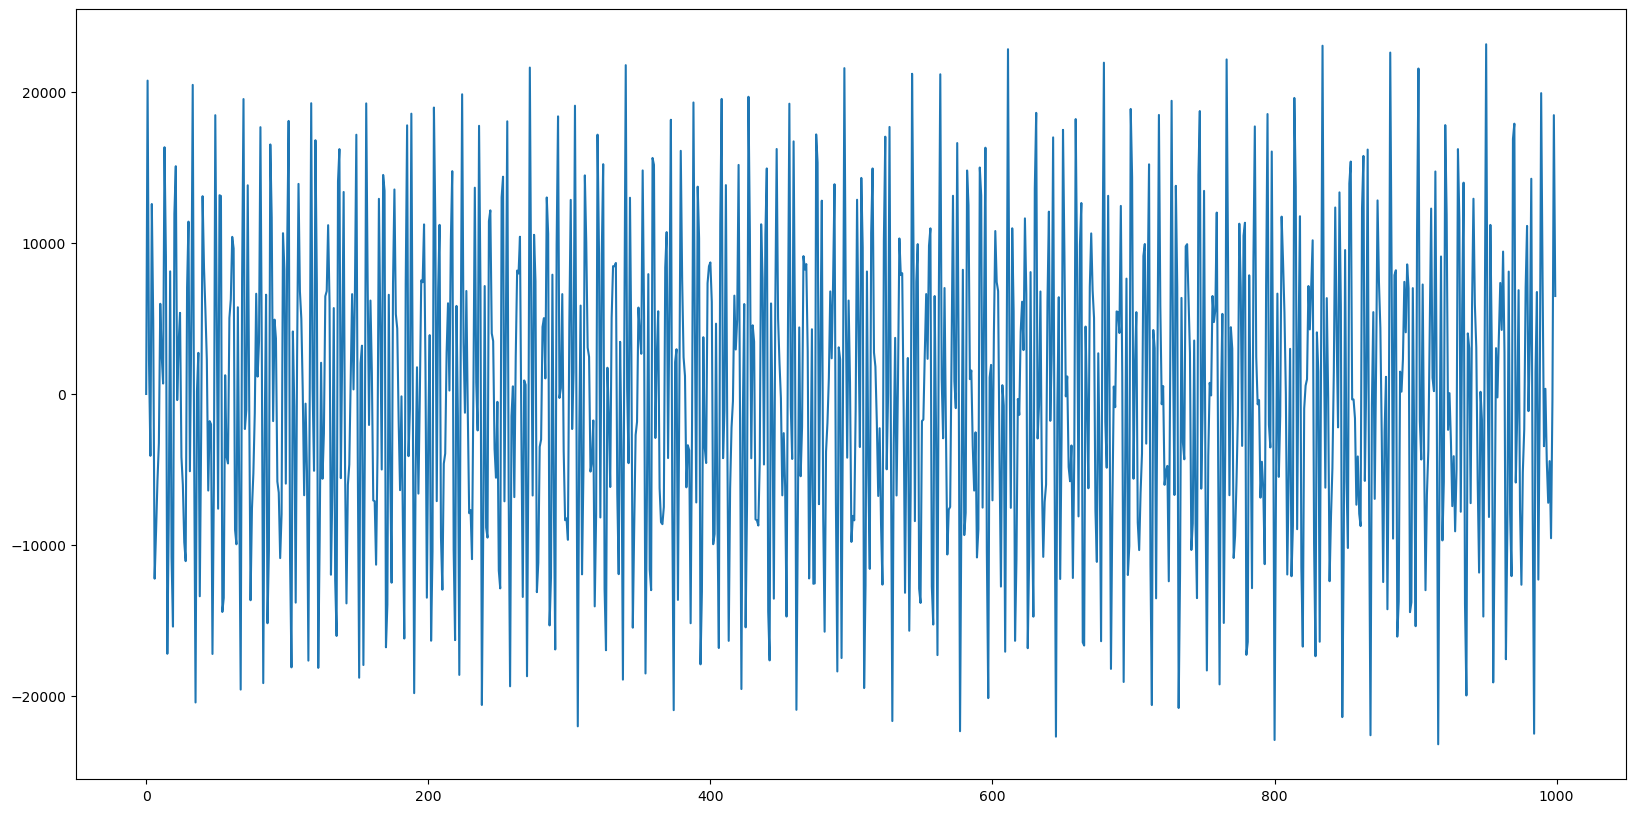

In [15]:
plt.figure(figsize=(20,10))

plt.plot(combinedWave[0:1000])
plt.show()

In [16]:
minCombined = np.min(combinedWave)
maxCombined = np.max(combinedWave)

for i in range(len(combinedWave)):
    combinedWave[i] = (((combinedWave[i] - minCombined)*(2637.0 - 65.4))/(maxCombined-minCombined)) + 65.4

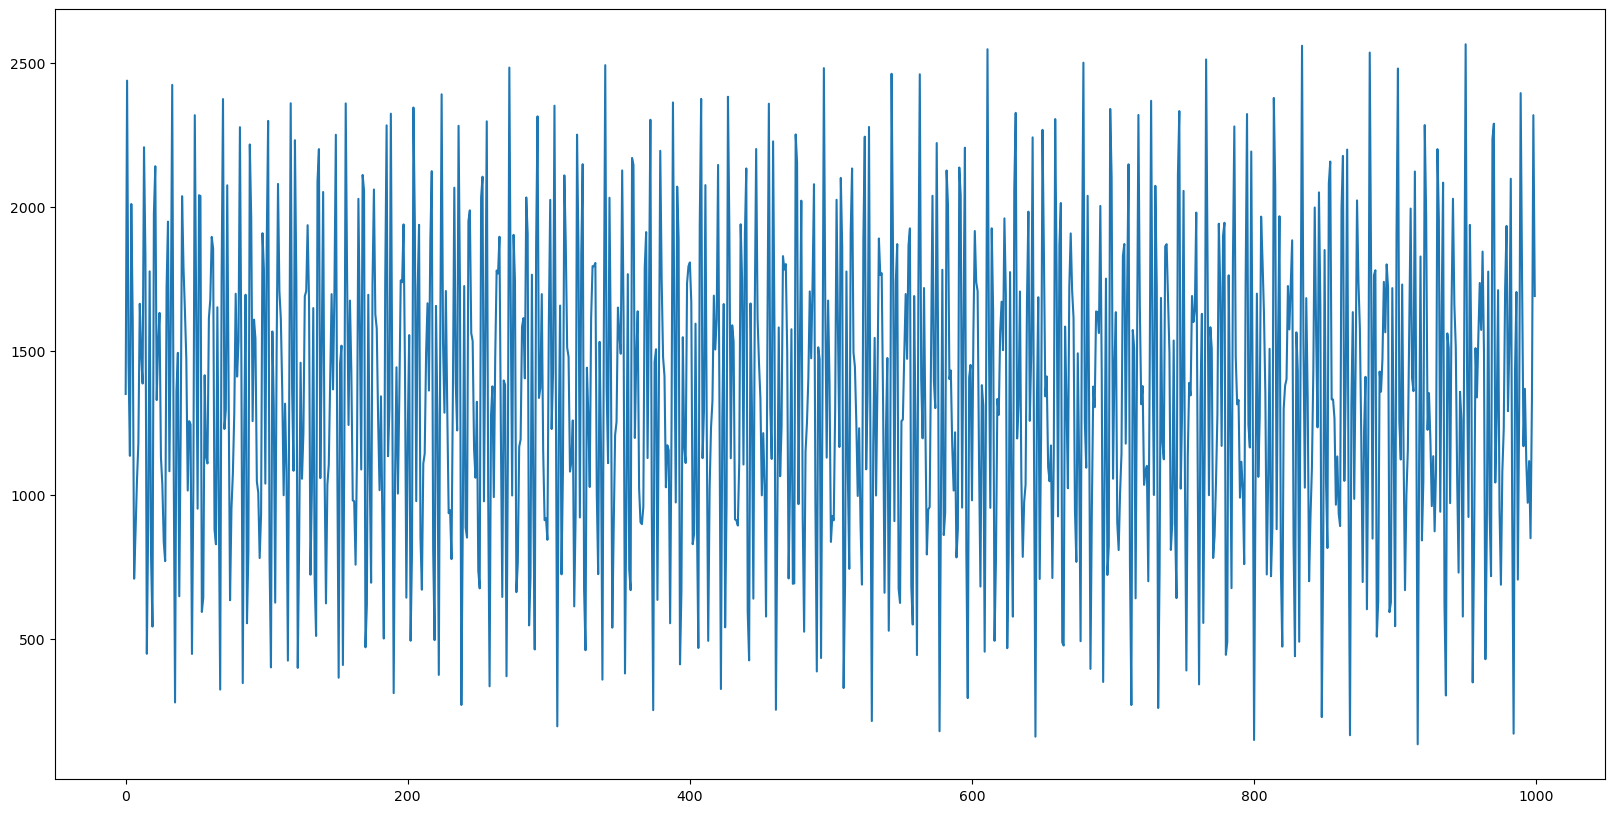

In [17]:
plt.figure(figsize=(20,10))

plt.plot(combinedWave[0:1000])
plt.show()

In [18]:
wavfile.write('video.wav', int(SAMPLE_RATE), combinedWave.astype(np.int16))